<a href="https://colab.research.google.com/github/guard1000/NLP_MCC/blob/master/5_1_BERT_BinaryClassify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[네이버 영화 후기로 긍/부정 판단]

MCC에 앞서 BERT로 이진분류 수행해봄

환경: 구글 Colab, GPU HW가속

데이터: 네이버 영화평점 데이터 15만건 학습용, 5만건 테스트용


[결론]
별도의 전처리 없이도 2 epochs 만에 정확도가 88%에 도달

--(BiLSTM 이나 어텐션 기법을 사용했을 시 보통 테스트셋에 대한 정확도가 86%) 



영화 후기 댓글은 길이가 짧으니까 뉴스데이터보단 VoC 데이터에 가까울듯.

뉴스데이터 한번 돌려보고 어지간하게 나오면 VoC에 적용하면 높은 F1으로 나올 것 같음



In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

Using TensorFlow backend.


In [2]:
#오늘의 핵심
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=b1cdce074486eb4ea9daf3dd027ba1837055e66c42ed1a1c33aff13c7083a526
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=4b386b20ddc2bdec237022ccd3d6632199b854b6ce1a82e9d963847a0f229ab7
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=5ed549b62638d69507a1d0b65419b9d3d793483c4f4c55b5842871604ad0e28a
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=ff3f5e53c013b8daca7d4cce2ae319c10208b5538c26b8b3b99a22af9fc6939f
  Stor

In [0]:
# keras_bert의 모듈들 import
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [0]:
# 네이버 영화 후기 & 평점 data 불러오기
train = pd.read_table("/content/drive/My Drive/data/ratings_train.txt")
test = pd.read_table("/content/drive/My Drive/data/ratings_test.txt")

In [24]:
train[:20]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [0]:
SEQ_LEN = 128      # 문장의 최대 길이. 더 짧으면 0 패딩, 길면 뒤는 잘라냄
BATCH_SIZE = 64    # 메모리 초과할까봐 일단 16으로 작게 함. 돌려보고 더 크게 키워도 됨
EPOCHS=2           # 에퐄도 학습 더 시켜도 됨
LR=1e-5            # Learning Rate 일단 작게 줘봄. 키워도 됨

pretrained_path ='/content/drive/My Drive/data/bert'
config_path = '/content/drive/My Drive/data/bert/bert_config.json'
checkpoint_path = '/content/drive/My Drive/data/bert/bert_model.ckpt'
vocab_path = '/content/drive/My Drive/data/bert/vocab.txt'

DATA_COLUMN = 'document' # 쿼리
LABEL_COLUMN = 'label'   # GT

In [0]:
# token_dict - voacab.txt 단어에 index 추가하는 딕셔너리
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
# inherit_Tokenizer 클래스 - Tokenizer 클래스를 상속 받아옴
# _tokenize() 함수 재정의
# --원래 클래스를 그대로 사용하면 입력한 문장이 완전 자모분리 되어버림
# --완전자모분리 : 인공지능 -> ㅇ ㅣ ㄴ ㄱ ㅗ ㅇ ㅈ ㄴ ㅡ ㅇ

class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
tokenizer = inherit_Tokenizer(token_dict)

In [29]:
# tokenizer 확인
# 버트에선 문장 시작에 [CLS],  문장 끝에 [SEP]이 추가됨
tokenizer.tokenize("SKT Infra AI/DT 추진Cell 최고야")

['[CLS]',
 'sk',
 '##t',
 'in',
 '##fra',
 'ai',
 '/',
 'dt',
 '추',
 '##진',
 '##cell',
 '최고',
 '##야',
 '[SEP]']

In [0]:
########################## 혹시 넘 길면 잘라서 해봐
#train = train[:10000]
#test = test[:1000]


In [0]:
# 버트 모형의 입력에 맞게 변형해주는 함수 정의
# --tokenizer.encode()로 버트 모형 토큰화 한 후 단어-인덱스에 맞춰 숫자로 바꿔줌
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

In [31]:
# 데이터 셋 분할 - 20만개나 되네...
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)

100%|██████████| 50000/50000 [00:06<00:00, 7772.24it/s]


In [32]:
train_x

[array([[  101,  9519,  9074, ...,     0,     0,     0],
        [  101,   100,   119, ...,     0,     0,     0],
        [  101,  9004, 32537, ...,     0,     0,     0],
        ...,
        [  101,  9638, 14153, ...,     0,     0,     0],
        [  101,  9751, 97707, ...,     0,     0,     0],
        [  101, 48556, 42428, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [33]:
# pre-trained 버트 모델의 인풋:
# -- 1) 숫자로 표현된 문장토큰
# -- 2) 앞문장인지 뒷문장인지 알려주는 문장 순서 벡터
print(len(train_x))
print(len(train_x[0]), len(train_x[1])) # 15만개
print(len(train_x[0][0]),len(train_x[1][0]))     # SEQ_LEN인 128
train_x
# train_x [ [ [128개 숫자]가 15만개], [ [128개 숫자]가 15만개] ] ]

2
150000 150000
128 128


[array([[  101,  9519,  9074, ...,     0,     0,     0],
        [  101,   100,   119, ...,     0,     0,     0],
        [  101,  9004, 32537, ...,     0,     0,     0],
        ...,
        [  101,  9638, 14153, ...,     0,     0,     0],
        [  101,  9751, 97707, ...,     0,     0,     0],
        [  101, 48556, 42428, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [0]:
# 버트 모형에 들어갈 인풋은 1)토큰, 2)세그먼트, 3)포지션
# 1) 토큰 - 토큰화 된 것이 인덱싱되어 숫자로 변환된 것
# 2) 세그먼트 - 앞문장인지 뒷문장인지 알려주는 숫자들
#     -- 지금은 그냥 앞문장 뒷문장 구분을 안하기 때문에 모두 0으로 패딩
# 3) 포지션 - 단어 순서에 따라서 자동으로 부여

def sentence_convert_data(data):
    global tokenizer #아까 만들어둔 inherit tokenizer 불러옴
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
    data_x = sentence_convert_data(sentences)
    return data_x

In [35]:
sentence_load_data(["SKT Infra AI/DT 추진Cell 최고야", "케라스 버트 사랑해요"])

100%|██████████| 2/2 [00:00<00:00, 1383.57it/s]

['[CLS]', 'sk', '##t', 'in', '##fra', 'ai', '/', 'dt', '추', '##진', '##cell', '최고', '##야', '[SEP]']
['[CLS]', '케', '##라', '##스', '버', '##트', '사', '##랑', '##해', '##요', '[SEP]']


[array([[   101,  66998,  10123,  10106,  31162,  11346,    120,  29169,
           9765,  18623, 110300,  83491,  21711,    102,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,   

In [0]:
# Pretrained Model을 로드
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [19]:
#모델 어캐 생겼냐 - 12 layer
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
# 사전학습 모델을 변형해보자
# input으로 토큰벡터, 세그먼트만 넣을꺼라서 inputs = model.inputs[:3]
# output은 사전학습 모델을 잘라주자. 
# --(outputs=Dense(1)) 맨 위 3층을 잘라내고 True/False를 알려주는 Dense(1)을 추가해보자
# --Dense(1) 로 하면 아웃풋이 하나! 긍정일수록 0, 부정일수록 1
# Radam으로 Gradient Descent 해준 후 모델을 return
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output

  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)

  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


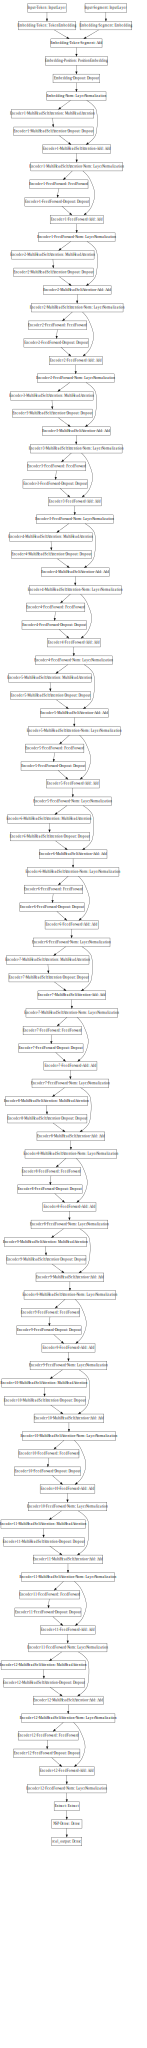

In [21]:
# 모델의 Flow 확인
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [38]:
# bert_model을 get_bert_finetuning_model함수로 불러오고
# bert_model.fit으로 파인튜닝
# 실시간 정확도 체크- validation_data = (test_x, test_y)
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=32, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

bert_model.save_weights("/content/drive/My Drive/data/bert/bert.h5")


Train on 150000 samples, validate on 50000 samples
Epoch 1/2
150000/150000 [==============================] - 4963s 33ms/step - loss: 0.3820 - acc: 0.8232 - val_loss: 0.3149 - val_acc: 0.8646
Epoch 2/2
150000/150000 [==============================] - 4954s 33ms/step - loss: 0.2785 - acc: 0.8817 - val_loss: 0.2880 - val_acc: 0.8765


In [0]:
# 모델 로드
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights("/content/drive/My Drive/data/bert/bert.h5")

In [0]:
# 테스트 데이터를 버트 모형에 넣을 수 있게 해주는 predict_convert_data 함수
# convert_data 함수와 다른 점 : test 데이터이므로 label은 고려하지 않음
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [41]:
test_set = predict_load_data(test)
test_set

100%|██████████| 50000/50000 [00:05<00:00, 8687.36it/s]


[array([[  101,  8911,   100, ...,     0,     0,     0],
        [  101,   175, 54998, ...,     0,     0,     0],
        [  101,  9303, 21711, ...,     0,     0,     0],
        ...,
        [  101,  8924, 67527, ...,     0,     0,     0],
        [  101,  9666, 14423, ...,     0,     0,     0],
        [  101,  9246, 32537, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [42]:
# 테스트 셋으로 예측
preds = bert_model.predict(test_set)
preds

array([[0.9489363 ],
       [0.75163645],
       [0.5094843 ],
       ...,
       [0.09614214],
       [0.00762698],
       [0.38541776]], dtype=float32)

In [43]:
from sklearn.metrics import classification_report
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87     24827
           1       0.86      0.90      0.88     25173

    accuracy                           0.88     50000
   macro avg       0.88      0.88      0.88     50000
weighted avg       0.88      0.88      0.88     50000

